# Capstone Project
## Machine Learning Engineer Nanodegree

In [2]:
import os
print (os.getcwd())
os.chdir('C:\\Users\husnu\Desktop\MachineLearningNanodegre\capstone')
print (os.getcwd())

C:\Users\husnu
C:\Users\husnu\Desktop\MachineLearningNanodegre\capstone


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, Embedding, SpatialDropout1D, LSTM, BatchNormalization

from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

Using TensorFlow backend.


In [3]:
#load and examine the data
data=pd.read_csv('train.tsv',  sep="\t")
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
data.shape

(156060, 4)

In [5]:
data['Sentiment'].nunique()

5

## Data Analysis
Looking at the data, multiple phrases are generated from a single sentence. 
There are 5 unique output classes or values for sentiments. They correspond to the values:<br>0 - negative<br>1 - somewhat negative<br>2 - neutral<br>3 - somewhat positive<br>4 - positive

In [6]:
print("Total Number of Samples(Phrases) = {}".format(data.shape[0]))
print("Total Number of Sentences = {}".format(len(data['SentenceId'].unique())))
data["Sentiment"].value_counts(sort=False)

Total Number of Samples(Phrases) = 156060
Total Number of Sentences = 8529


0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

As can be seen more phrases are neutral(sentiment 2), followed by somewhat positive or negative (sentiment 1 or 3). Much fewer are strictly positive or negative (sentiment 0 or 4) which makes the job of classification much more difficult. 

Looking at Phrases:


In [7]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\husnu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
data['Phrase_words'] = data["Phrase"].apply(word_tokenize)
data.head() 

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_words
0,1,1,A series of escapades demonstrating the adage ...,1,"[A, series, of, escapades, demonstrating, the,..."
1,2,1,A series of escapades demonstrating the adage ...,2,"[A, series, of, escapades, demonstrating, the,..."
2,3,1,A series,2,"[A, series]"
3,4,1,A,2,[A]
4,5,1,series,2,[series]


In [9]:
def get_num_words_per_sample(sample_texts):
    num_words = [len(s) for s in sample_texts]
    return num_words
word_len = get_num_words_per_sample(data['Phrase_words'])
print("Maximum number of words in a Phrase = {}".format(np.max(word_len)))
print("Minimum number of words in a Phrase = {}".format(np.min(word_len)))
print("Mean word length of a Phrase = {0:.3f}".format(np.mean(word_len)))
print("Median word length of a Phrase = {}".format(np.median(word_len)))

Maximum number of words in a Phrase = 53
Minimum number of words in a Phrase = 0
Mean word length of a Phrase = 7.208
Median word length of a Phrase = 5.0


### Data Visualization

Data Samples are distributed among the various classes as follows

Text(0,0.5,'Number of Reviews')

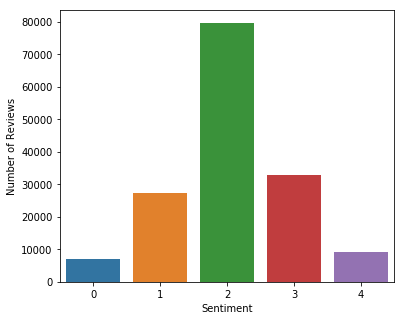

In [10]:
x = np.array(data['Sentiment'].value_counts(sort=False).index)
y = np.array(data['Sentiment'].value_counts(sort=False).values)
plt.figure(figsize=(6,5))
sns.barplot(x,y)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

Here is a plot of most frequently occuring words in the data

In [11]:
def plot_frequency_distribution_of_words(sample_texts,
                                          num_words=30):
    # Create args required for vectorizing.
    kwargs = {
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'stop_words' : 'english' #remove the stop words in english
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are words and values are
    # idxices). 
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all words in the index order from the vocabulary.
    all_words = list(vectorizer.get_feature_names())
    num_words = min(num_words, len(all_words))

    # Add up the counts per word ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort words and counts by frequency and get top words.
    all_counts, all_words = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_words), reverse=True)])
    nwords = list(all_words)[:num_words]
    counts = list(all_counts)[:num_words]

    idx = np.arange(num_words)
    plt.figure(figsize=(9,5))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Most Frequently found words')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of words')
    plt.xticks(idx, nwords, rotation=45)
    plt.show()


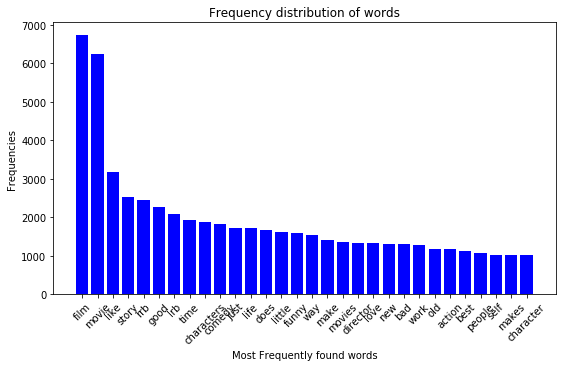

In [12]:
# This shows most frequent words in all the data samples 
plot_frequency_distribution_of_words(data['Phrase'])

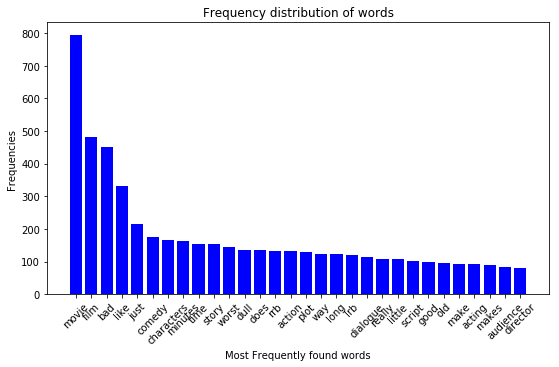

In [13]:
# Most frequent words in Negative Sentiments
neg_data = data[data['Sentiment']==0]
plot_frequency_distribution_of_words(neg_data['Phrase'])

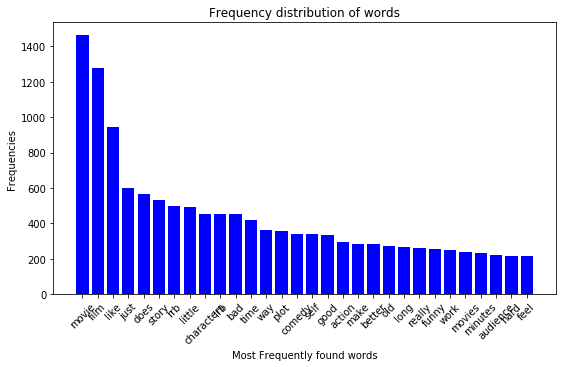

In [14]:
# Most frequent words in Somewhat Negative Sentiments
sneg_data = data[data['Sentiment']==1]
plot_frequency_distribution_of_words(sneg_data['Phrase'])

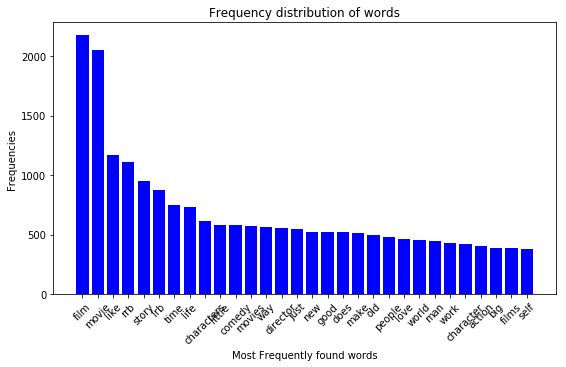

In [15]:
# Most frequent words in Neutral Sentiments
neutral_data = data[data['Sentiment']==2]
plot_frequency_distribution_of_words(neutral_data['Phrase'])

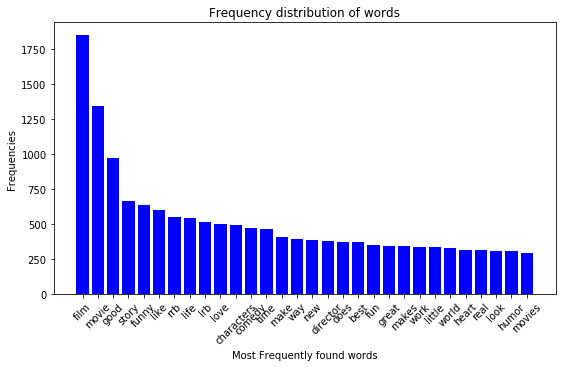

In [16]:
# Most frequent words in Somewhat Positive Sentiments
spos_data = data[data['Sentiment']==3]
plot_frequency_distribution_of_words(spos_data['Phrase'])

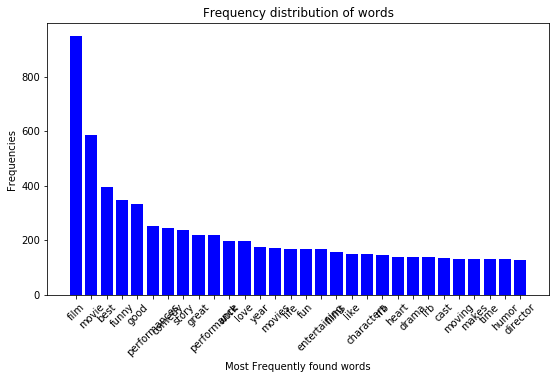

In [17]:
# Most frequent words in Somewhat Positive Sentiments
pos_data = data[data['Sentiment']==4]
plot_frequency_distribution_of_words(pos_data['Phrase'])

Some Observations based on these graphs:
-  Negative reviews include words like bad, worst, dull.
-  Positive reviews include words like best, funny, good, great, love.
-  Neutral reviews have words like story, time, life, characters.<br><br>

### Data Preprocessing


In [18]:
# split data into training and testing set with 75/25 ratio. Also used stratify 
# to maintain the class distribution in training and testing set
all_train = data['Phrase']
y = data["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(data['Phrase'], y, test_size=0.25, 
                                                    random_state =None, 
                                                    stratify=data['Sentiment'])
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(117045,) (117045,)
(39015,) (39015,)


In [19]:
# Use CountVectorizer to clean the data, remove stop words and generate n-grams 
# Use a maximum of 500 words
count_vec = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,3), 
                            max_features=500)
xtrain_c = count_vec.fit_transform(X_train)
xtest_c = count_vec.fit_transform(X_test)
xtrain_c.shape

(117045, 500)

In [20]:
# Another vectorizer used, which gives normalized results is TF-IDF
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode', # Remove accents during the preprocessing step.
    analyzer='word', 
    stop_words='english', # remove english stop words
    ngram_range=(1, 3), 
    max_features=300000)
vectorizer.fit(all_train)
xtrain_f =  vectorizer.transform(X_train) 
xtest_f =  vectorizer.transform(X_test)

xtrain_f.shape

(117045, 131668)

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [22]:
# Cleaning and Preprocessing Data for Convolutional Neural Networks, remove stopwords, create 
# equal length input sequences and one hot encode them. 
stopwords = set(nltk.corpus.stopwords.words("english"))
max_vocab = 2000
def remove_stopwords(word_list):
    return [word.lower() for word in word_list if word.lower() not in stopwords]

#Add a new column for preprocessing, which tokenizes, removes stopwords and then 
# joins the words back together
data['Phrase_mod'] = data['Phrase'].apply(word_tokenize).apply(remove_stopwords).apply(lambda x: " ".join(x))

data["num_words"] = data["Phrase_mod"].apply(len)
data = data[data["num_words"] > 0]

tokenizer = text.Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(data["Phrase_mod"])
x_tokenized=tokenizer.texts_to_sequences(data["Phrase_mod"])
X_train_conv, X_test_conv, y_train_conv, y_test_conv = train_test_split(x_tokenized, data['Sentiment'],
                                                                        test_size=0.25, random_state = None,
                                                                        stratify=data['Sentiment'])


In [23]:
# One hot encode the Phrases and the labels for the Convolutional Neural Network
X_train_conv_cat = tokenizer.sequences_to_matrix(X_train_conv, mode='binary')
X_test_conv_cat = tokenizer.sequences_to_matrix(X_test_conv, mode='binary')
y_train_conv = to_categorical(y_train_conv)
y_test_conv = to_categorical(y_test_conv)
print(X_train_conv_cat.shape, y_train_conv.shape)
print(X_test_conv_cat.shape, y_test_conv.shape)

(116437, 2000) (116437, 5)
(38813, 2000) (38813, 5)


In [24]:
# Loading word2vec embeddings for use in LSTM 
import io
from time import time
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
    return data

t1 = time()
embeddings = load_vectors('wiki-news-300d-1M.vec')
t2 = time()
print("Time taken load word2vec = {:.2f}".format(t2-t1))



Time taken load word2vec = 203.22


In [25]:
X_train_seq = {}
X_test_seq = {}


In [26]:
# Further processing for x_tokenized for using the loaded word embeddings 
rnn_tokenizer = text.Tokenizer()
rnn_tokenizer.fit_on_texts(data["Phrase_mod"])
word_index = rnn_tokenizer.word_index
x_tokenized_rnn=tokenizer.texts_to_sequences(data["Phrase_mod"])

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(data["Phrase_mod"], data["Sentiment"], test_size=0.25, 
                                                    random_state =None, stratify=data['Sentiment'])
#print(X_train_rnn.shape)
# Prepairing data for using the word embeddings in LSTM RNN
X_train_seq = sequence.pad_sequences(rnn_tokenizer.texts_to_sequences(X_train_rnn), maxlen=32)
X_test_seq = sequence.pad_sequences(rnn_tokenizer.texts_to_sequences(X_test_rnn), maxlen=32)

nf = 0
word_nf = []
# Generate mapping for current words using available word2vec model
mapping = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    embed_vec = embeddings.get(word)
    if embed_vec is not None:
        mapping[i] = np.asarray(embed_vec)
    else:
        #print("Embedding not found for '{}'".format(word))
        word_nf.append(word)
        nf += 1
print("Embedding not found for {} word".format(nf))

Embedding not found for 868 word


In [27]:
y_train_rnn = to_categorical(y_train_rnn)
y_test_rnn = to_categorical(y_test_rnn)

### Benchmark Model - Naive Bayes Classifier


In [28]:
cv_accuracy_dict = {}
cv_f1score_dict = {}
tf_accuracy_dict = {}
tf_f1score_dict = {}

def run_and_eval_model(name, cv_model, tf_model, cv_train, tf_train, cv_test, tf_test, 
                       y_tr, y_tst): 
                       #cv_acc_dict, cv_f1_dict, tf_acc_dict, tf_f1_dict):
    t1 = time()
    count_vec_model = cv_model.fit(cv_train, y_tr)
    t2 = time()
    print("Model", name,  "using CountVec fitted in {0:.2f} seconds".format(t2-t1))

    predictionsc = count_vec_model.predict(cv_test)
    acc_score = round((accuracy_score(y_tst, predictionsc) * 100), 3)
    f1_sc = round((f1_score(y_tst, predictionsc, average='weighted')), 3)
    print("Model" , name, "using CountVectorizer Accuracy Score = {0:.3f}".format(acc_score))
    print("& F1 Score = {0:.3f}".format(f1_sc))
    cv_accuracy_dict[name] = acc_score
    cv_f1score_dict[name] = f1_sc

    # Using Tfidf Vectorizer
    t1 = time()
    tf_idf_model = tf_model.fit(tf_train, y_tr)
    t2 = time()
    print("Model", name, "using TfidfVec fitted in {:.2f} seconds".format(t2-t1))

    predictionst = tf_idf_model.predict(tf_test)
    acc_score_t = round((accuracy_score(y_tst, predictionst) * 100), 3)
    f1_score_t = round((f1_score(y_tst, predictionst, average='weighted')), 3)
    print("Model", name, "using TfIdfVectorizer Accuracy Score = {0:.3f}".format(acc_score_t))
    print("& F1 Score = {0:.3f}".format(f1_score_t))
    tf_accuracy_dict[name] = acc_score_t
    tf_f1score_dict[name] = f1_score_t

In [29]:
# Benchmark Model - Multinomial Naive Bayes
run_and_eval_model("NaiveBayes", MultinomialNB(), MultinomialNB(),xtrain_c, xtrain_f, 
                    xtest_c, xtest_f, y_train, y_test)

Model NaiveBayes using CountVec fitted in 0.52 seconds
Model NaiveBayes using CountVectorizer Accuracy Score = 49.058
& F1 Score = 0.384
Model NaiveBayes using TfidfVec fitted in 0.91 seconds
Model NaiveBayes using TfIdfVectorizer Accuracy Score = 61.066
& F1 Score = 0.558


The benchmark model used is __Multinomial Naive Bayes Classifier__.
-  Random guessing gives 20% accuracy
-  Naive Bayes with CountVectorizer gives 49.058% accuracy which is a lot better than random guessing. 
-  Naive Bayes with TfidfVectorizer does much better and gives 61.066% accuracy 
- Let's see how much better we can do with some other Algorithms.


Let's try the following Supervised Learning Classifiers:
 - Logistic Regression
 - Linear Support Vector Machine
 - Random Forest

In [30]:
# Logistic Regression
run_and_eval_model("LogisticRegression", LogisticRegression(), LogisticRegression(),
                    xtrain_c, xtrain_f, xtest_c, xtest_f, y_train, y_test)

Model LogisticRegression using CountVec fitted in 6.45 seconds
Model LogisticRegression using CountVectorizer Accuracy Score = 49.381
& F1 Score = 0.409
Model LogisticRegression using TfidfVec fitted in 7.87 seconds
Model LogisticRegression using TfIdfVectorizer Accuracy Score = 61.538
& F1 Score = 0.572


In [31]:
# Linear Support Vector Machine
run_and_eval_model("LinearSVC", LinearSVC(), LinearSVC(), xtrain_c, xtrain_f, 
                    xtest_c, xtest_f, y_train, y_test)

Model LinearSVC using CountVec fitted in 70.16 seconds
Model LinearSVC using CountVectorizer Accuracy Score = 49.327
& F1 Score = 0.407
Model LinearSVC using TfidfVec fitted in 9.46 seconds
Model LinearSVC using TfIdfVectorizer Accuracy Score = 64.621
& F1 Score = 0.638


In [32]:
# Random Forest Classifier
run_and_eval_model("RandomForest", RandomForestClassifier(random_state=None), RandomForestClassifier(random_state=None),
                    xtrain_c, xtrain_f, xtest_c, xtest_f, y_train, y_test)


Model RandomForest using CountVec fitted in 26.67 seconds
Model RandomForest using CountVectorizer Accuracy Score = 47.784
& F1 Score = 0.406
Model RandomForest using TfidfVec fitted in 3884.20 seconds
Model RandomForest using TfIdfVectorizer Accuracy Score = 63.414
& F1 Score = 0.626


In [33]:
print(cv_accuracy_dict)

{'RandomForest': 47.783999999999999, 'LinearSVC': 49.326999999999998, 'LogisticRegression': 49.381, 'NaiveBayes': 49.058}


In [34]:
print(tf_accuracy_dict)

{'RandomForest': 63.414000000000001, 'LinearSVC': 64.620999999999995, 'LogisticRegression': 61.537999999999997, 'NaiveBayes': 61.066000000000003}


In [35]:
# Neural Network Model Architecture used
input_shape = X_train_conv_cat.shape[1:]
model = Sequential()
model.add(Dropout(rate=0.2, input_shape=input_shape))
model.add(Dense(230, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 230)               460230    
_________________________________________________________________
dropout_2 (Dropout)          (None, 230)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1155      
Total params: 461,385
Trainable params: 461,385
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compile the model - adam seems to be the best optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [37]:
#Test the accuracy of the model before training, it could be anything close to the random guess
score = model.evaluate(X_test_conv_cat, y_test_conv, verbose = 1)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

38813/38813 [==============================] - 23s 601us/step
Test accuracy: 20.7018%


In [38]:
from keras.callbacks import ModelCheckpoint

# Set the model up for ModelCheckPoint, train the model
checkpointer = ModelCheckpoint(filepath='./bestfit', 
                               verbose=1, save_best_only=True)
hist = model.fit(X_train_conv_cat, y_train_conv, batch_size=50, epochs=5,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=1, shuffle=True)

Train on 93149 samples, validate on 23288 samples
Epoch 1/5
93149/93149 [==============================] - 83s 893us/step - loss: 1.1215 - acc: 0.5666 - val_loss: 1.0210 - val_acc: 0.6026

Epoch 00001: val_loss improved from inf to 1.02102, saving model to ./bestfit
Epoch 2/5
93149/93149 [==============================] - 287s 3ms/step - loss: 1.0302 - acc: 0.6024 - val_loss: 1.0009 - val_acc: 0.6154

Epoch 00002: val_loss improved from 1.02102 to 1.00086, saving model to ./bestfit
Epoch 3/5
93149/93149 [==============================] - 53s 566us/step - loss: 0.9970 - acc: 0.6168 - val_loss: 0.9858 - val_acc: 0.6188

Epoch 00003: val_loss improved from 1.00086 to 0.98583, saving model to ./bestfit
Epoch 4/5
93149/93149 [==============================] - 51s 546us/step - loss: 0.9693 - acc: 0.6274 - val_loss: 0.9793 - val_acc: 0.6231

Epoch 00004: val_loss improved from 0.98583 to 0.97930, saving model to ./bestfit
Epoch 5/5
93149/93149 [==============================] - 51s 546us/step

In [39]:
# Load the best fit model and find its accuracy on test set
model.load_weights('./bestfit')
score = model.evaluate(X_test_conv_cat, y_test_conv, verbose=1)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

38813/38813 [==============================] - 32s 821us/step
Test accuracy: 62.2601%


#### Neural Network Accuracy - 62.26 %

Let's try a Deep Neural Network with an LSTM next:

In [40]:
# Input Layer
input_layer = Input((32,))

# Embedding Layer
embed1 = Embedding(len(word_index) + 1, 300, weights=[mapping], trainable=False)(input_layer)
embed2 = SpatialDropout1D(0.25)(embed1)

# LSTM with dropout
lstm1 = LSTM(256, dropout=0.25)(embed2)

# Batch Normalization
batch1 = BatchNormalization()(lstm1)

# Dense layers with Dropout
d1 = Dense(128, activation="relu")(batch1)
dropout1 = Dropout(0.5)(d1)
d2 = Dense(64, activation="relu")(dropout1)
dropout2 = Dropout(0.25)(d2)
output_layer = Dense(5, activation="softmax")(dropout2)

# Compile the model 
lstm = Model(inputs=input_layer, outputs=output_layer)
lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
lstm.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 32, 300)           4567200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 32, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [41]:
lstm.fit(X_train_seq, y_train_rnn, batch_size=50, epochs=5)


Epoch 1/5
116437/116437 [==============================] - 858s 7ms/step - loss: 1.0634 - acc: 0.5675
Epoch 2/5
116437/116437 [==============================] - 845s 7ms/step - loss: 0.9871 - acc: 0.5957
Epoch 3/5
116437/116437 [==============================] - 818s 7ms/step - loss: 0.9637 - acc: 0.6027
Epoch 4/5
116437/116437 [==============================] - 817s 7ms/step - loss: 0.9472 - acc: 0.6102
Epoch 5/5
116437/116437 [==============================] - 673s 6ms/step - loss: 0.9325 - acc: 0.6167


In [42]:
lstm.evaluate(X_test_seq, y_test_rnn)

38813/38813 [==============================] - 81s 2ms/step


[0.89590975316101007, 0.62824311441581904]

In [48]:
score1 =lstm.evaluate(X_test_seq, y_test_rnn)
accuracy = 100*score1[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

38813/38813 [==============================] - 74s 2ms/step
Test accuracy: 62.8243%


### Accuracy of Deep Neural Network with LSTM = 62.8243%

### Result Visualizations

In [50]:
# Plot accuracy scores of top performing models
models = ["NaiveBayes(CV)", "LinearSVC(TV)", "NeuralNetwork", "NN with LSTM"]
accuracy = [49.058, 64.621, 62.26, 62.82]

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

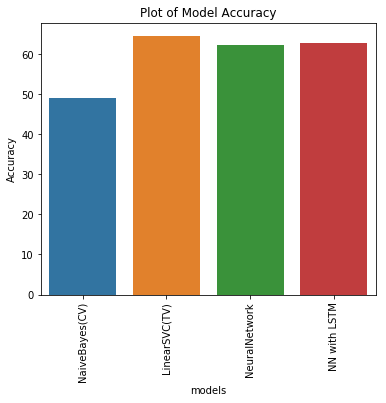

In [51]:
x = np.array(models)
y = np.array(accuracy)
plt.figure(figsize=(6,5))
sns.barplot(x,y)
plt.title('Plot of Model Accuracy')
plt.xlabel('models')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

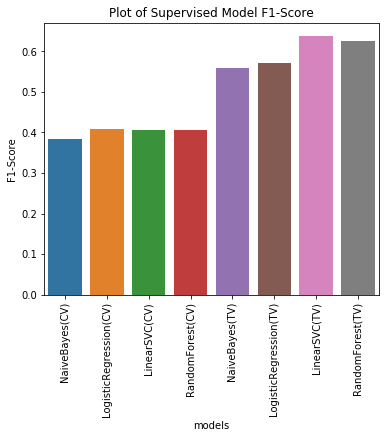

In [52]:
# Plot F1-score of Supervised models
models = ["NaiveBayes(CV)", "LogisticRegression(CV)", "LinearSVC(CV)", "RandomForest(CV)",
          "NaiveBayes(TV)",  "LogisticRegression(TV)", "LinearSVC(TV)", "RandomForest(TV)"]
f1score = [0.384, 0.409, 0.407, 0.406, 0.558, 0.572, 0.638,0.626]
import seaborn as sns
x = np.array(models)
y = np.array(f1score)
plt.figure(figsize=(6,5))
sns.barplot(x,y)
plt.title('Plot of Supervised Model F1-Score')
plt.xlabel('models')
plt.ylabel('F1-Score')
plt.xticks(rotation=90)

In [53]:
# Plot the accuracy scores of all the models and evaluate the results
models = ["NaiveBayes(CV)", "LogisticReg(CV)", "LinearSVC(CV)", "RandomForest(CV)",
          "NaiveBayes(TV)",  "LogisticReg(TV)", "LinearSVC(TV)", "RandomForest(TV)", 
          "NeuralNetwork", "NN with LSTM"]
accuracy = [49.058, 49.381, 49.327, 47.784, 61.066, 61.538, 64.621, 63.414, 62.2601, 62.8243]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

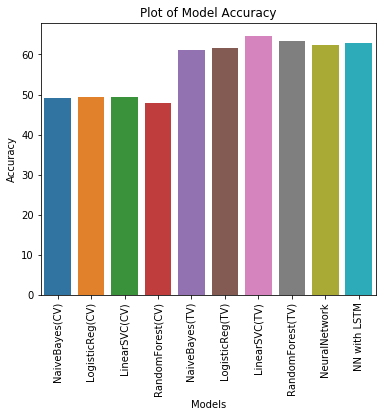

In [54]:
x = np.array(models)
y = np.array(accuracy)
plt.figure(figsize=(6,5))
sns.barplot(x,y)
plt.title('Plot of Model Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)

#### Some key Observations:
  1. Benchmark Model, Naive Bayes with Count Vectorizer, had an accuracy of 49.058%. The best model in this study was The Support Vector Machine using TfIdfVectorizer  which had a 64.621% accuracy. 
  2. It was observed that Data preprocessed with TfIdfVectorizer performed much better in all the Supervised Learning Algorithms as compared to the CountVectorizer. The accuracy was better by about 10%. The F1-score was also better. 
  3. Neural Networks did not do better. In fact LinearSVC gave a better accuracy.
  5. LSTM gave the good accuracy, which could be increased by some more parameter tuning.

### Key Results

1. Support Vector Machine using TfIdfVectorizer  is the best model for Sentiment Analysis of a multiclass classification problem.
2. An improvement of about 13.76% in accuracy score was achieved using Neural Networks with LSTM over the Benchmark model of NaiveBayes.
